In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

# from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow_addons as tfa
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, MaxPool2D



print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.10.0


In [45]:
WORK_DIR = './monkeypox-skin-lesion-dataset/Augmented Images/Augmented Images/'

CLASSES = [ 'Monkeypox_augmented',
            'Others_augmented']

IMG=224

IMAGE_SIZE = [224, 224]
DIM = (IMG,IMG )

In [46]:
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=3192, shuffle=False)

Found 3192 images belonging to 2 classes.


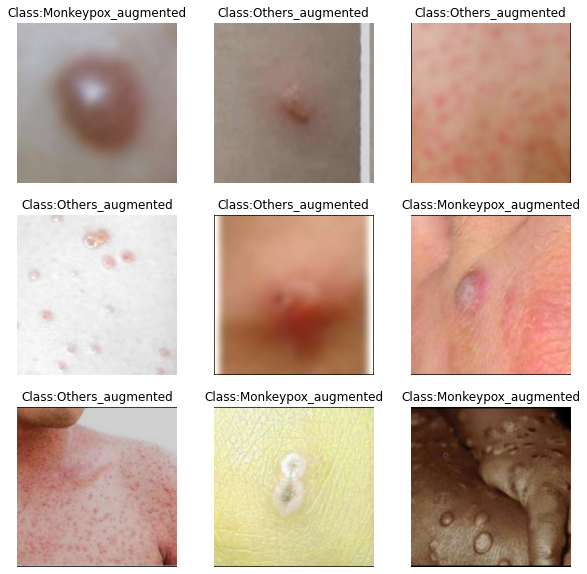

In [47]:
from random import randint
def show_images(generator,y_pred=None):
    """
    Input: An image generator,predicted labels (optional)
    Output: Displays a grid of 9 images with lables
    """
    
    # get image lables
    labels =dict(zip([0,1], CLASSES))
    
    # get a batch of images
    x,y = generator.next()
    
    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 3192)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Display Train Images
show_images(train_data_gen)

In [48]:
train_data, train_labels = train_data_gen.next()
print(train_data.shape, train_labels.shape)


(3192, 224, 224, 3) (3192, 2)


In [49]:
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.1, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
print(train_data.shape)

(2297, 224, 224, 3)


In [50]:
def conv_block(filters, act='relu'):
    """Defining a Convolutional NN block for a Sequential CNN model. """
    
    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(BatchNormalization())
    block.add(MaxPool2D())
    
    return block
def dense_block(units, dropout_rate, act='relu'):
    """Defining a Dense NN block for a Sequential CNN model. """
    
    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))
    
    return block

In [51]:
def construct_model(act='relu'):
    """Constructing a Sequential CNN architecture for performing the classification task. """
    
    model = Sequential([
        Input(shape=(*IMAGE_SIZE, 3)),
        Conv2D(16, 3, activation=act, padding='same'),
        Conv2D(16, 3, activation=act, padding='same'),
        MaxPool2D(),
        conv_block(32),
        MaxPool2D(),
        conv_block(64),
        conv_block(128),
        Dropout(0.2),
        conv_block(256),
        Dropout(0.2),
        Flatten(),
       
        dense_block(256, 0.3),
        dense_block(128, 0.2),
        dense_block(32, 0.2),
        Dense(2, activation='sigmoid')        
    ], name = "cnn_model")

    return model

In [52]:
#Defining a custom callback function to stop training our model when accuracy goes above 99%
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, MaxPool2D
import tensorflow_addons as tfa
import tensorflow as tf

#Defining a custom callback function to stop training our model when accuracy goes above 99%

class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()

#EarlyStopping callback to make sure model is always learning
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

In [56]:
#Defining other parameters for our CNN model
from tensorflow.keras import Sequential, Input


model = construct_model()

METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'), 
           tfa.metrics.F1Score(num_classes=2)]

CALLBACKS = [my_callback]
    
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(),
              metrics=METRICS)

model.summary()

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_162 (Conv2D)         (None, 224, 224, 16)      448       
                                                                 
 conv2d_163 (Conv2D)         (None, 224, 224, 16)      2320      
                                                                 
 max_pooling2d_66 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 sequential_84 (Sequential)  (None, 56, 56, 32)        14016     
                                                                 
 max_pooling2d_68 (MaxPoolin  (None, 28, 28, 32)       0         
 g2D)                                                            
                                                                 
 sequential_85 (Sequential)  (None, 14, 14, 64)        55

In [57]:
EPOCHS = 100

history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), callbacks=CALLBACKS,batch_size=32, epochs=EPOCHS)

Epoch 1/100
72/72 [==============================] - 10s 98ms/step - loss: 0.7318 - acc: 0.6121 - auc: 0.6408 - f1_score: 0.6055 - val_loss: 0.7937 - val_acc: 0.5687 - val_auc: 0.5500 - val_f1_score: 0.3625
Epoch 2/100
72/72 [==============================] - 5s 75ms/step - loss: 0.6329 - acc: 0.6744 - auc: 0.7208 - f1_score: 0.6665 - val_loss: 0.9698 - val_acc: 0.5687 - val_auc: 0.6567 - val_f1_score: 0.3625
Epoch 3/100
72/72 [==============================] - 5s 75ms/step - loss: 0.6240 - acc: 0.6905 - auc: 0.7324 - f1_score: 0.6725 - val_loss: 0.9994 - val_acc: 0.5687 - val_auc: 0.6602 - val_f1_score: 0.3625
Epoch 4/100
72/72 [==============================] - 5s 75ms/step - loss: 0.5834 - acc: 0.7201 - auc: 0.7659 - f1_score: 0.7053 - val_loss: 0.7757 - val_acc: 0.6000 - val_auc: 0.6624 - val_f1_score: 0.4545
Epoch 5/100
72/72 [==============================] - 5s 75ms/step - loss: 0.5590 - acc: 0.7196 - auc: 0.7857 - f1_score: 0.7046 - val_loss: 0.6542 - val_acc: 0.6504 - val_auc:

KeyboardInterrupt: 